In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:

state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [3]:
wapo=pd.read_csv("ois_clean.csv")
wapo.head()

,Unnamed: 0,name,date,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,0,Tim Elliot,2015-01-02,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,1,Lewis Lee Lembke,2015-01-02,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,2,John Paul Quintero,2015-01-03,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,3,Matthew Hoffman,2015-01-04,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,4,Michael Rodriguez,2015-01-04,other,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [4]:
armed_df=wapo[["state", "armed"]]

state_counts=armed_df.groupby("state").count()
state_counts=state_counts.reset_index(drop=False)
state_counts.head()

,state,armed
0,AK,19
1,AL,63
2,AR,31
3,AZ,143
4,CA,463


In [5]:
from config import api_key
url = "https://api.census.gov/data/2016/acs/acs1?get=NAME,B01003_001E,B17001_002E&for=state:*&key="
query_url= url + api_key

In [6]:
census_data = requests.get(query_url).json()

In [7]:
print(census_data)

[['NAME', 'B01003_001E', 'B17001_002E', 'state'], ['Alabama', '4863300', '810231', '01'], ['Alaska', '741894', '71566', '02'], ['Arizona', '6931071', '1107464', '04'], ['Arkansas', '2988248', '499225', '05'], ['California', '39250017', '5525524', '06'], ['Colorado', '5540545', '598736', '08'], ['Connecticut', '3576452', '339128', '09'], ['Delaware', '952065', '108211', '10'], ['District of Columbia', '681170', '120308', '11'], ['Florida', '20612439', '2973512', '12'], ['Georgia', '10310371', '1603013', '13'], ['Hawaii', '1428557', '129569', '15'], ['Idaho', '1683140', '237445', '16'], ['Illinois', '12801539', '1621508', '17'], ['Indiana', '6633053', '906077', '18'], ['Iowa', '3134693', '356378', '19'], ['Kansas', '2907289', '342544', '20'], ['Kentucky', '4436974', '794060', '21'], ['Louisiana', '4681666', '918187', '22'], ['Maine', '1331479', '161749', '23'], ['Maryland', '6016447', '567715', '24'], ['Massachusetts', '6811779', '686597', '25'], ['Michigan', '9928300', '1451936', '26'],

In [8]:
census_pd = pd.DataFrame(census_data, columns= ["State Name", "Estimated Population", "Below Poverty Level", "State ID"])
census_pd=census_pd.drop(census_pd.index[[0, 9, 52]])
census_pd=census_pd.reset_index(drop=True)
census_pd.head()

,State Name,Estimated Population,Below Poverty Level,State ID
0,Alabama,4863300,810231,01
1,Alaska,741894,71566,02
2,Arizona,6931071,1107464,04
3,Arkansas,2988248,499225,05
4,California,39250017,5525524,06


In [11]:
census_pd["est pop"] = census_pd["Estimated Population"].astype("int") 
census_pd["Below Poverty Level"] = census_pd["Below Poverty Level"].astype("int") 
census_pd["% below pov"]=census_pd["Below Poverty Level"] / census_pd["est pop"] * 100
census_pd["state"]=census_pd["State Name"].map(state_abbrev)
poverty_df=census_pd[["state", "% below pov", "est pop"]]



merged_df=pd.merge(poverty_df, state_counts, how="inner", on="state")
merged_df=merged_df.rename(columns={"armed":"incidents"})
merged_df["inc per 100k people"]=merged_df["incidents"] / (merged_df["est pop"] / 100000)

merged_df

,state,% below pov,est pop,incidents,inc per 100k people
0,AL,16.660107,4863300,63,1.295417
1,AK,9.646392,741894,19,2.561013
2,AZ,15.978252,6931071,143,2.063173
3,AR,16.706277,2988248,31,1.037397
4,CA,14.077762,39250017,463,1.179617
5,CO,10.806446,5540545,90,1.624389
6,CT,9.482247,3576452,10,0.279607
7,DE,11.365926,952065,9,0.945314
8,FL,14.425813,20612439,189,0.916922
9,GA,15.547578,10310371,90,0.872907


Text(0,0.5,'% of State Population below poverty level')

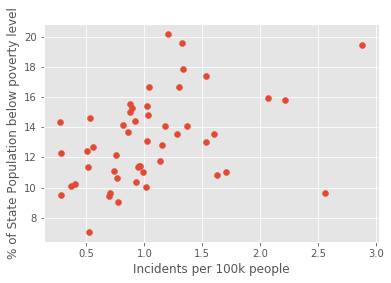

In [12]:
plt.scatter(merged_df["inc per 100k people"], merged_df["% below pov"])
plt.xlabel("Incidents per 100k people")
plt.ylabel("% of State Population below poverty level")

In [ ]:
# race_criteria = "B02001_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E"
race_criteria="B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E"
race_url = f"https://api.census.gov/data/2016/acs/acs1?get=NAME,{race_criteria}&for=state:*&key="
race_query= race_url + api_key

In [ ]:
race_data = requests.get(race_query).json()

In [ ]:

race_pd = pd.DataFrame(race_data, columns= ["State Name","White alone","Black or African American alone",
                                            "American Indian and Alaska Native alone","Asian alone",
                                            "Native Hawaiian and Other Pacific Islander alone","Some other race alone",
                                            "Two or more races","Hispanic or Latino","State ID"])

race_pd=race_pd.drop(race_pd.index[[0, 9, 52]])
race_pd=race_pd.reset_index(drop=True)
race_pd